In [1]:
import torch_geometric as pyg
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
import numpy as np
import seaborn as sns
from utils import *

/home/jamesl/anaconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_dgl_to_pyg(dgl_dataset):
    # Assuming the DGL dataset has only one graph for simplicity
    dgl_graph = dgl_dataset[0]

    # Convert edge indices from DGL to PyG format
    src, dst = dgl_graph.edges()
    edge_index = torch.stack([src, dst], dim=0)

    # Extract node features
    # Assuming 'feat' is the name of the node features in the DGL graph
    if 'feat' in dgl_graph.ndata:
        x = dgl_graph.ndata['feat']
    else:
        raise ValueError("Node features 'feat' not found in the DGL graph.")

    # Extract labels
    # Assuming 'label' is the name of the node labels in the DGL graph
    if 'label' in dgl_graph.ndata:
        y = dgl_graph.ndata['label']
    else:
        raise ValueError("Node labels 'label' not found in the DGL graph.")
    
    # Create the PyTorch Geometric Data object
    pyg_data = Data(x=x, edge_index=edge_index, y=y)

    return pyg_data

In [3]:
def edge_homophily(data:Data):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    edge_index = data.edge_index
    # edge_index = edge_index.to(device)
    y = data.y
    # y = y.to(device)
    y_y = y.unsqueeze(0) == y.unsqueeze(1)
    edge_homophily = torch.sum(y_y[edge_index[0], edge_index[1]]).item()
    # edge_index.detach().cpu()
    # y.detach().cpu()
    return edge_homophily / edge_index.shape[1]

In [4]:
dataset = dgl.data.SquirrelDataset()

Done loading data from cached files.


In [5]:
data = convert_dgl_to_pyg(dataset)
cora = Planetoid(root='data', name='Cora')
print(edge_homophily(cora))
edge_homophily(data)

0.8099658961727927


0.2239430974833351

In [6]:
dataset = dgl.data.SquirrelDataset()
data = convert_dgl_to_pyg(dataset)
torch.unique(data.x, return_counts=True)

Done loading data from cached files.


(tensor([0., 1.]), tensor([10771412,    93477]))

In [7]:
from tqdm import tqdm
dataset_name_ls = ['CoraGraphDataset', 'CiteseerGraphDataset', 'PubmedGraphDataset', 'TexasDataset', 'WisconsinDataset', 'CornellDataset', 'SquirrelDataset', 'ChameleonDataset']
edge_homo_ls = []
feat_homo_ls = []
for dataset_name in tqdm(dataset_name_ls):
    dataset = dgl.data.__getattribute__(dataset_name)()
    data = convert_dgl_to_pyg(dataset)
    edge_homo = edge_homophily(data)
    feat_homo = feature_homophily_score(data)
    edge_homo_ls.append(edge_homo)
    feat_homo_ls.append(feat_homo)
with open('homo_hetro_csv/edge_feat_homophily_scores.csv', 'w') as f:
    f.write('dataset,edge_homophily,feat_homophily\n')
    for name, edge, feat in zip(dataset_name_ls, edge_homo_ls, feat_homo_ls):
        f.write(','.join([name, str(edge), str(feat)]) + '\n')

  0%|          | 0/8 [00:00<?, ?it/s]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 25%|██▌       | 2/8 [00:00<00:00,  6.09it/s]

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 75%|███████▌  | 6/8 [00:01<00:00,  3.78it/s]

Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

Done loading data from cached files.


In [8]:
lev_score_ls = []
for dataset_name in tqdm(dataset_name_ls):
    dataset = dgl.data.__getattribute__(dataset_name)()
    data = convert_dgl_to_pyg(dataset)
    lev_score = leverage_score(data)
    lev_score_ls.append(lev_score)
lev_img_path = 'img/leverage_score_distribution/'
for name, lev_score in zip(dataset_name_ls, lev_score_ls):
    sns.histplot(lev_score)
    plt.xlabel('leverage score')
    plt.xlim(-0.05, 1.05)
    plt.title(name + 'leverage score')
    plt.savefig(lev_img_path + name + '_leverage_score_dist.png')
    plt.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 12%|█▎        | 1/8 [00:00<00:02,  3.06it/s]

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 38%|███▊      | 3/8 [00:02<00:03,  1.32it/s]

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Done loading data from cached files.


 62%|██████▎   | 5/8 [00:02<00:01,  2.76it/s]

Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.


 88%|████████▊ | 7/8 [00:04<00:00,  1.51it/s]

Done loading data from cached files.


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


In [9]:
import re
def plot_double_bars(names, list1, list2):
    """
    Plots a bar chart with two bars for each name, representing values from list1 and list2.

    Parameters:
    - names: List of names (strings).
    - list1: List of numbers corresponding to the first group.
    - list2: List of numbers corresponding to the second group.
    """
    # Check if the lengths of the lists match
    if not (len(names) == len(list1) == len(list2)):
        raise ValueError("All input lists must have the same length.")
    
    # Create an index for each tick position
    x = np.arange(len(names))
    
    # Bar width
    width = 0.35  
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, np.round(list1, 2), width, label='edge homophily')
    bars2 = ax.bar(x + width/2, np.round(list2, 2), width, label='feat homophily')
    
    # Adding some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Datasets')
    ax.set_ylabel('Homophily Score')
    ax.set_title('Homophily Scores of Datasets')
    ax.set_xticks(x)
    pattern = re.compile(r'(Graph)?Dataset')
    ax.set_xticklabels([pattern.sub('', name) for name in names])
    ax.legend()
    
    # Attach a text label above each bar in *bars1* and *bars2*, displaying its height.
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    plt.savefig('img/homophily_score_distribution/homophily_vs_all_datasets.png')
    plt.show()

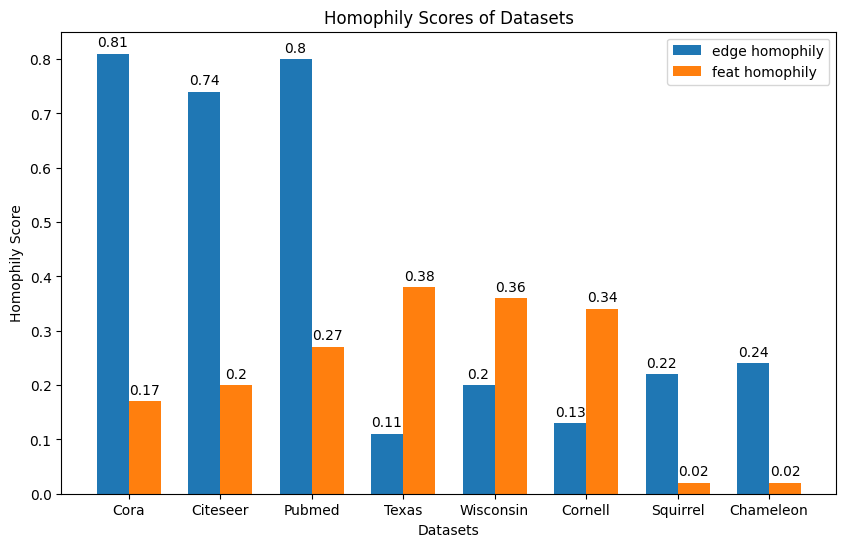

In [10]:
plot_double_bars(dataset_name_ls, edge_homo_ls, feat_homo_ls)

In [11]:
product_ls = []
for dataset_name in tqdm(dataset_name_ls):
    dataset = dgl.data.__getattribute__(dataset_name)()
    data = convert_dgl_to_pyg(dataset)
    X = data.x
    norm = torch.norm(X, dim=1)
    normed_X = X / norm.unsqueeze(1)
    XXT = normed_X @ normed_X.T
    n = X.shape[0]
    product = torch.zeros((n**2 - n)//2)
    prev_pos = 0
    crnt_pos = 0
    for i in range(X.shape[0]-1):
        prev_pos = crnt_pos
        crnt_pos += n-1-i
        product[prev_pos:crnt_pos] = XXT[i, i+1:]
    product = product[torch.nonzero(product)]
    product_ls.append(product)

  0%|          | 0/8 [00:00<?, ?it/s]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 25%|██▌       | 2/8 [00:00<00:00,  6.15it/s]

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


 50%|█████     | 4/8 [00:01<00:01,  2.55it/s]

Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.


 88%|████████▊ | 7/8 [00:03<00:00,  2.03it/s]

Done loading data from cached files.


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

Done loading data from cached files.


In [12]:
pattern = re.compile(r'(Graph)?Dataset')
for name, product in zip(dataset_name_ls, product_ls):
    sns.histplot(product)
    plt.xlabel("product")
    plt.title(fr'{name} x_i^tx_j')
    plt.legend().remove()
    plt.savefig(f'img/homophily_ingredient_distribution/{name}_product.png')
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

In [13]:
product_ls[-2].shape

torch.Size([4113649, 1])

In [14]:
torch.sum(product_ls[-2].squeeze() <= 1) / len(product_ls[-2])

tensor(0.7947)

In [17]:
sns.histplot(product_ls[-2])
plt.xlabel("product")
plt.title(fr'{dataset_name_ls[-2]} x_i^tx_j')
plt.legend().remove()
plt.savefig(f'img/homophily_ingredient_distribution/{dataset_name_ls[-2]}_product.png')
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [16]:
torch.min(product_ls[-2]), torch.max(product_ls[-2])

(tensor(nan), tensor(nan))